# 训练你的物体检测器

In [1]:
!pip install gluoncv

    100% |████████████████████████████████| 512kB 10.3MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 14.0MB/s ta 0:00:01
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import gluoncv as gcv
import mxnet as mx

# 准备训练集

In [2]:
import os

class DetectionDataset(gcv.data.VOCDetection):
    CLASSES = ['cocacola', 'cocacola-zero', 'juice', 'noodles', 'hand']
    def __init__(self, root):
        self._im_shapes = {}
        self._root = os.path.expanduser(root)
        self._transform = None
        self._items = [(self._root, x.strip('.xml')) for x in os.listdir(self._root) if x.endswith('.xml')]
        self._anno_path = os.path.join('{}', '{}.xml')
        self._image_path = os.path.join('{}', '{}.jpg')
        self.index_map = dict(zip(self.classes, range(self.num_class)))
        self._label_cache = self._preload_labels()
        
    def __str__(self):
        detail = self._root
        return self.__class__.__name__ + '(' + detail + ')'
    
    @property
    def classes(self):
        return self.CLASSES
    
    @property
    def num_class(self):
        return len(self.classes)
        
train_dataset = DetectionDataset('../images/v1/train')
print('class_names:', train_dataset.classes)
print('num_images:', len(train_dataset))

class_names: ['cocacola', 'cocacola-zero', 'juice', 'noodles', 'hand']
num_images: 20


# 可视化数据

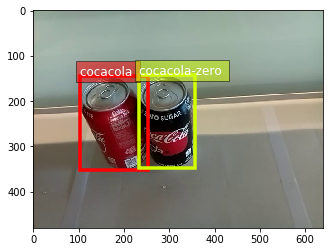

In [3]:
from matplotlib import pyplot as plt
from gluoncv.utils import viz

sample = train_dataset[0]
train_image = sample[0]
train_label = sample[1]

ax = viz.plot_bbox(
    train_image.asnumpy(),
    train_label[:, :4],
    labels=train_label[:, 4:5],
    class_names=train_dataset.classes)
plt.show()


# 定义训练过程

In [6]:
import time
from datetime import datetime
from mxnet import autograd
from gluoncv.data.batchify import Tuple, Stack, Pad

def train_model(train_dataset, epochs=50):
#     ctx = mx.gpu(0)
    ctx = mx.cpu(0)
    net = gcv.model_zoo.get_model('ssd_512_resnet50_v1_custom', classes=train_dataset.classes, transfer='coco')
    net.collect_params().reset_ctx(ctx)
    width, height = 512, 512  # suppose we use 512 as base training size
    train_transform = gcv.data.transforms.presets.ssd.SSDDefaultTrainTransform(width, height)
    gcv.utils.random.seed(233)
    
    batch_size = 4
    # you can make it larger(if your CPU has more cores) to accelerate data loading
    num_workers = 4

    with autograd.train_mode():
        _, _, anchors = net(mx.nd.zeros((1, 3, height, width), ctx))
    anchors = anchors.as_in_context(mx.cpu())
    train_transform = gcv.data.transforms.presets.ssd.SSDDefaultTrainTransform(width, height, anchors)
    batchify_fn = Tuple(Stack(), Stack(), Stack())
    train_loader = mx.gluon.data.DataLoader(
        train_dataset.transform(train_transform),
        batch_size,
        shuffle=True,
        batchify_fn=batchify_fn,
        last_batch='rollover',
        num_workers=num_workers)
    
    mbox_loss = gcv.loss.SSDMultiBoxLoss()
    ce_metric = mx.metric.Loss('CrossEntropy')
    smoothl1_metric = mx.metric.Loss('SmoothL1')
    for k, v in net.collect_params().items():
        if 'convpredictor' not in k:
            # freeze upper layers
            v.grad_req = 'null'
    trainer = mx.gluon.Trainer(
        net.collect_params(), 'sgd',
        {'learning_rate': 0.001, 'wd': 0.0005, 'momentum': 0.9})
    
    net.hybridize(static_alloc=True, static_shape=True)
    
    for epoch in range(epochs):
        tic = time.time()
        btic = time.time()
        
        for i, batch in enumerate(train_loader):
            data = mx.gluon.utils.split_and_load(batch[0], ctx_list=[ctx], batch_axis=0)
            cls_targets = mx.gluon.utils.split_and_load(batch[1], ctx_list=[ctx], batch_axis=0)
            box_targets = mx.gluon.utils.split_and_load(batch[2], ctx_list=[ctx], batch_axis=0)
            
            with autograd.record():
                cls_preds = []
                box_preds = []
                for x in data:
                    cls_pred, box_pred, _ = net(x)
                    cls_preds.append(cls_pred)
                    box_preds.append(box_pred)
                sum_loss, cls_loss, box_loss = mbox_loss(
                    cls_preds, box_preds, cls_targets, box_targets)
                autograd.backward(sum_loss)
            # since we have already normalized the loss, we don't want to normalize
            # by batch-size anymore
            trainer.step(1)
            ce_metric.update(0, [l * batch_size for l in cls_loss])
            smoothl1_metric.update(0, [l * batch_size for l in box_loss])
            name1, loss1 = ce_metric.get()
            name2, loss2 = smoothl1_metric.get()
            print('[Epoch {}][Batch {}], Speed: {:.3f} samples/sec, {}={:.3f}, {}={:.3f}'.format(
                epoch, i, batch_size/(time.time()-btic), name1, loss1, name2, loss2))
            btic = time.time()
    return net
        


# 开始训练

In [7]:
epochs = 200
net = train_model(train_dataset, epochs=epochs)
save_file = 'object_detector_epoch{}_{}.params'.format(epochs, datetime.now().strftime("%m_%d_%Y_%H_%M_%S"))
net.save_parameters(save_file)
print('Saved model to disk: ' + save_file)

[Epoch 0][Batch 0], Speed: 1.336 samples/sec, CrossEntropy=12.310, SmoothL1=0.531
[Epoch 0][Batch 1], Speed: 4.086 samples/sec, CrossEntropy=11.275, SmoothL1=0.871
[Epoch 0][Batch 2], Speed: 4.057 samples/sec, CrossEntropy=10.733, SmoothL1=0.799
[Epoch 0][Batch 3], Speed: 3.969 samples/sec, CrossEntropy=10.301, SmoothL1=0.883
[Epoch 0][Batch 4], Speed: 4.049 samples/sec, CrossEntropy=10.008, SmoothL1=1.017
[Epoch 1][Batch 0], Speed: 1.655 samples/sec, CrossEntropy=9.740, SmoothL1=0.988
[Epoch 1][Batch 1], Speed: 4.053 samples/sec, CrossEntropy=9.528, SmoothL1=0.956
[Epoch 1][Batch 2], Speed: 3.998 samples/sec, CrossEntropy=9.328, SmoothL1=0.980
[Epoch 1][Batch 3], Speed: 4.055 samples/sec, CrossEntropy=9.160, SmoothL1=0.933
[Epoch 1][Batch 4], Speed: 4.114 samples/sec, CrossEntropy=8.972, SmoothL1=0.934
[Epoch 2][Batch 0], Speed: 1.766 samples/sec, CrossEntropy=8.764, SmoothL1=0.936
[Epoch 2][Batch 1], Speed: 3.991 samples/sec, CrossEntropy=8.583, SmoothL1=0.925
[Epoch 2][Batch 2], Spe